In [2]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy as np
import string
import random
import string
from sklearn import linear_model

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
def readGz(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)

def readCSV(path):
    f = gzip.open(path, 'rt')
    f.readline()
    for l in f:
        u,b,r = l.strip().split(',')
        r = int(r)
        yield u,b,r

In [5]:
allRatings = []
for l in readCSV("train_Interactions.csv.gz"):
    allRatings.append(l)

In [6]:
ratingsTrain = allRatings[:190000]
ratingsValid = allRatings[190000:]
ratingsPerUser = defaultdict(list)
ratingsPerItem = defaultdict(list)
bookPerUser = defaultdict(list)
userPerBook = defaultdict(list)
for u,b,r in ratingsTrain:
    ratingsPerUser[u].append((b,r))
    ratingsPerItem[b].append((u,r))
    bookPerUser[u].append(b)
    userPerBook[b].append(u)



In [7]:
def Jaccard(s1, s2):
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [8]:
allbooks = set()
for _, book, _ in allRatings:
    allbooks.add(book)
allbooks = list(allbooks)

In [9]:
ratingsValidBinary = [(user, book, 1) for user, book, _ in ratingsValid]
for user, book, _ in ratingsValid:
    newBook = random.choice(allbooks)
    while newBook in [b for b, _ in ratingsPerUser[user]]:
        newBook = random.choice(allbooks)
    ratingsValidBinary.append((user, newBook, 0))

In [10]:
random.shuffle(ratingsValidBinary)

In [11]:
bookCount = defaultdict(int)
totalRead = 0
threshold = 0.7085

for _ ,book,_ in ratingsTrain:
    bookCount[book] += 1
    totalRead += 1

mostPopular = [(bookCount[x], x) for x in bookCount]
mostPopular.sort()
mostPopular.reverse()

count = 0
popular = set()
for ic, i in mostPopular:
    count += ic
    popular.add(i)
    if count > totalRead * threshold: 
        print(ic, i)
        break

correct = 0
for _, book, predict in ratingsValidBinary:
    correct += predict == (book in popular)

acc1 = correct / len(ratingsValidBinary)
print(acc1)

print("Popularity model: ", acc1)

32 b70000668
0.7492
Popularity model:  0.7492


In [ ]:
#need to beat 75.68% //32 read is the threshold

In [17]:
def combined(thresh1, thresh2):
    ans = {}
    max_popularity = max(len(ratingsPerItem[b]) for b in ratingsPerItem)
    for user, book, _ in ratingsValidBinary:
        users_for_book = set(u for u, _ in ratingsPerItem[book])
        bprime = set(b for b, _ in ratingsPerUser[user] if b != book)
        
        maxjaccard = 0
        for b in bprime:
            jac = Jaccard(set(u for u, _ in ratingsPerItem[b]), users_for_book)
            maxjaccard = max(maxjaccard, jac)
        #popularity_score = len(users_for_book) / max_popularity

        if maxjaccard > thresh1 and bookCount[book] > thresh2:
            ans[(user, book)] = 1
        else:
            ans[(user, book)] = 0


    correct = sum(1 for user, book, r in ratingsValidBinary if ans.get((user, book)) == r)
    accuracy = correct / len(ratingsValidBinary) if ratingsValidBinary else 0

    one, zero = 0, 0
    for val in ans.values():
        if val: one += 1
        else: zero += 1

    print("One: ", one)
    print("Zero: ", zero)


    TP, FP, TN, FN = 0, 0, 0, 0
    for user, book, r in ratingsValidBinary:
        if ans.get((user, book)): # if 1
            if r == 1:
                TP += 1
            else:
                FP += 1
        else:
            if r == 1:
                FN += 1
            else:
                TN += 1
    print("TP: ", TP)
    print("FP: ", FP)
    print("TN: ", TN)
    print("FN: ", FN)
    return accuracy

In [18]:
#print(combined(0.0088, 37))
from skopt import gp_minimize

def objective(params):
    t1, t2 = params
    return -combined(t1, int(t2))  # Negative because we minimize

res = gp_minimize(objective, [(0, 0.01), (20, 75)], n_calls=50)
print("Optimal Thresholds: ", res.x)
print("Optimal Accuracy: ", -res.fun)

One:  6096
Zero:  13903
TP:  5203
FP:  893
TN:  9107
FN:  4797
One:  4569
Zero:  15430
TP:  4010
FP:  559
TN:  9441
FN:  5990
One:  4796
Zero:  15203
TP:  4037
FP:  759
TN:  9241
FN:  5963
One:  7209
Zero:  12790
TP:  5898
FP:  1311
TN:  8689
FN:  4102
One:  6016
Zero:  13983
TP:  5163
FP:  853
TN:  9147
FN:  4837
One:  5783
Zero:  14216
TP:  4762
FP:  1021
TN:  8979
FN:  5238
One:  5519
Zero:  14480
TP:  4743
FP:  776
TN:  9224
FN:  5257
One:  7183
Zero:  12816
TP:  5870
FP:  1313
TN:  8687
FN:  4130
One:  2384
Zero:  17615
TP:  2144
FP:  240
TN:  9760
FN:  7856
One:  8932
Zero:  11067
TP:  6874
FP:  2058
TN:  7942
FN:  3126
One:  9294
Zero:  10705
TP:  7049
FP:  2245
TN:  7755
FN:  2951
One:  5699
Zero:  14300
TP:  4938
FP:  761
TN:  9239
FN:  5062
One:  8726
Zero:  11273
TP:  6726
FP:  2000
TN:  8000
FN:  3274
One:  9294
Zero:  10705
TP:  7049
FP:  2245
TN:  7755
FN:  2951
One:  7572
Zero:  12427
TP:  6188
FP:  1384
TN:  8616
FN:  3812
One:  8410
Zero:  11589
TP:  6621
FP:  1789
TN:

In [19]:
pip install catboost

   ---------------------------------------- 0.0/101.8 MB ? eta -:--:--
    --------------------------------------- 1.6/101.8 MB 8.4 MB/s eta 0:00:12
   - -------------------------------------- 3.4/101.8 MB 8.0 MB/s eta 0:00:13
   - -------------------------------------- 5.0/101.8 MB 7.9 MB/s eta 0:00:13
   -- ------------------------------------- 6.8/101.8 MB 7.9 MB/s eta 0:00:12
   --- ------------------------------------ 8.4/101.8 MB 8.0 MB/s eta 0:00:12
   ---- ----------------------------------- 10.2/101.8 MB 8.0 MB/s eta 0:00:12
   ---- ----------------------------------- 12.1/101.8 MB 8.0 MB/s eta 0:00:12
   ----- ---------------------------------- 13.6/101.8 MB 8.0 MB/s eta 0:00:12
   ----- ---------------------------------- 15.2/101.8 MB 8.0 MB/s eta 0:00:11
   ------ --------------------------------- 17.0/101.8 MB 8.1 MB/s eta 0:00:11
   ------- -------------------------------- 18.9/101.8 MB 8.1 MB/s eta 0:00:11
   -------- ------------------------------- 20.4/101.8 MB 8.1 MB/

  You can safely remove it manually.
  You can safely remove it manually.


In [ ]:
"""
combined(0.0022, 23)
One:  8537
Zero:  11460
TP:  6673
FP:  3327
TN:  8135
FN:  1865
0.7404

print(combined(0.0088, 37))
One:  9958
Zero:  10039
TP:  7457
FP:  2502
TN:  7498
FN:  2543
0.74775

Optimal Thresholds:  [0.02642941668361511, np.int64(33)]
Optimal Accuracy:  0.7511
"""

In [ ]:
# Finding optimal thresholds
best_accuracy = 0
optimal_thresh1 = 0
optimal_thresh2 = 0

# Testing thresholds in range
thresh1_range = np.linspace(0, 1, 10)  # Adjust granularity as needed
thresh2_range = range(1, max(bookCount.values()) + 1)

for t1 in thresh1_range:
    for t2 in thresh2_range:
        acc = combined(t1, t2)
        if acc > best_accuracy:
            best_accuracy = acc
            optimal_thresh1 = t1
            optimal_thresh2 = t2

optimal_thresh1, optimal_thresh2, best_accuracy


TP:  5829
FP:  4171
TN:  8805
FN:  1195
Threshold: 0.035, Accuracy: 0.7317


KeyboardInterrupt: 

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

max_popularity = max(len(ratingsPerItem[b]) for b in ratingsPerItem)

def extract_features(user, book):
    users_for_book = set(u for u, _ in ratingsPerItem[book])
    bprime = set(b for b, _ in ratingsPerUser[user] if b != book)
    jaccard_similarities = [Jaccard(users_for_book, set(u for u, _ in ratingsPerItem[b])) for b in bprime] if bprime else [0]
    
    # Jaccard-based features
    max_jaccard = max(jaccard_similarities)
    mean_jaccard = np.mean(jaccard_similarities)
    count_high_jaccard = sum(1 for j in jaccard_similarities if j > 0.5)
    
    # Popularity-based features
    popularity_score = len(users_for_book) / max_popularity
    user_popularity_avg = np.mean([len(set(u for u, _ in ratingsPerItem[b])) / max_popularity for b, _ in ratingsPerUser[user]])
    
    # User-specific feature
    user_total_books = len(ratingsPerUser[user])
    
    return [max_jaccard, mean_jaccard, count_high_jaccard, popularity_score, user_popularity_avg, user_total_books]

features = [extract_features(user, book) for user, book, _ in ratingsTrainBinary]
labels = [predict for _, _, predict in ratingsTrainBinary]

features = np.array(features)
labels = np.array(labels)
scaler = StandardScaler()
features = scaler.fit_transform(features)
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(features, labels)


features_valid = [extract_features(user, book) for user, book, _ in ratingsValidBinary]
labels_valid = [predict for _, _, predict in ratingsValidBinary]


features_valid = np.array(features_valid)
labels_valid = np.array(labels_valid)

features_valid = scaler.transform(features_valid)

predictions = clf.predict(features_valid)
accuracy = accuracy_score(labels_valid, predictions)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.6052


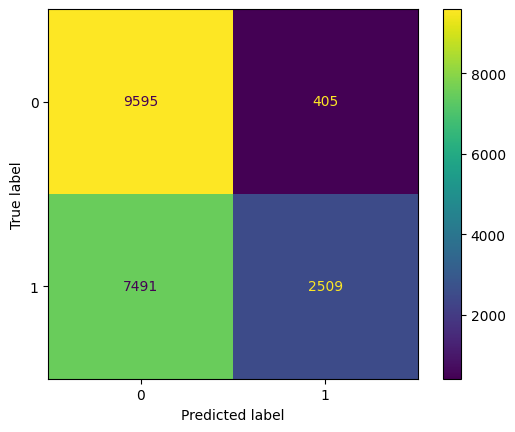

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labels_valid, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
#naive jaccard 

In [ ]:
# def solve(thresh1):
#     ans = {}
#     for user, book, _ in ratingsValidBinary:
#         users_for_book = set(u for u, _ in ratingsPerItem[book])
#         bprime = set(b for b, _ in ratingsPerUser[user] if b != book)
        
#         max_jaccard = 0
#         for b in bprime:
#             jaccard = Jaccard(set(u for u, _ in ratingsPerItem[b]), users_for_book)
#             max_jaccard = max(max_jaccard, jaccard)
        
#         ans[(user, book)] = 1 if max_jaccard > thresh1 else 0

#     correct = sum(1 for user, book, r in ratingsValidBinary if ans.get((user, book)) == r)
#     accuracy = correct / len(ratingsValidBinary) if ratingsValidBinary else 0
#     return accuracy
    


In [ ]:
# solve(0.004)

0.69855

In [ ]:
#weighted jaccard

In [ ]:
#1.415

In [ ]:
# read_books = set() 
# def solve(alpha, combined_thresh):
#     read_books.clear()
#     max_popularity = max(len(ratingsPerItem[b]) for b in ratingsPerItem)

#     for user, book, _ in ratingsValidBinary:
#         users_for_book = set(u for u, _ in ratingsPerItem[book])
#         bprime = set(b for b, _ in ratingsPerUser[user] if b != book)
        
#         max_jaccard = 0
#         for b in bprime:
#             jaccard = Jaccard(set(u for u, _ in ratingsPerItem[b]), users_for_book)
#             max_jaccard = max(max_jaccard, jaccard)
             
#         popularity_score = len(users_for_book) / max_popularity
#         if(len(users_for_book) > 50):
#             read_books.add(book)
#             continue
#         combined_score = alpha * max_jaccard + (1 - alpha) * popularity_score
#         if combined_score > combined_thresh:
#             read_books.add(book) 

#     correct = 0
#     for _, book, predict in ratingsValidBinary:
#         correct += (predict == 1 and book in read_books) or (predict == 0 and book not in read_books)
    
#     acc = correct / len(ratingsValidBinary)
#     return acc


In [ ]:
#Optimal Alpha Threshold: 0.55, Optimal Combined Threshold: 0.02, Best Accuracy: 0.75725

In [ ]:
print(solve(0.1, 0.032))

0.7494


In [ ]:
import numpy as np
def gs(alpha_range, combined_range):
    best_accuracy = 0
    best_alpha_thresh = None
    best_combined_thresh = None
    for alpha_thresh in alpha_range:
        for combined_thresh in combined_range:
            accuracy = solve(alpha_thresh, combined_thresh)
            print(f"Alpha Threshold: {alpha_thresh}, Combined Threshold: {combined_thresh}, Accuracy: {accuracy}")
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_alpha_thresh = alpha_thresh
                best_combined_thresh = combined_thresh

    return best_alpha_thresh, best_combined_thresh, best_accuracy

alpha_range = np.arange(0.5, 0.56, 0.01) 
combined_range = np.arange(0.02, 0.024, 0.001) 

best_alpha_thresh, best_combined_thresh, best_accuracy = gs(
    alpha_range, combined_range
)
print(f"Optimal Alpha Threshold: {best_alpha_thresh}, Optimal Combined Threshold: {best_combined_thresh}, Best Accuracy: {best_accuracy}")


Alpha Threshold: 0.5, Combined Threshold: 0.02, Accuracy: 0.738
Alpha Threshold: 0.5, Combined Threshold: 0.021, Accuracy: 0.739
Alpha Threshold: 0.5, Combined Threshold: 0.022000000000000002, Accuracy: 0.7413
Alpha Threshold: 0.5, Combined Threshold: 0.023000000000000003, Accuracy: 0.742
Alpha Threshold: 0.51, Combined Threshold: 0.02, Accuracy: 0.7385
Alpha Threshold: 0.51, Combined Threshold: 0.021, Accuracy: 0.7394
Alpha Threshold: 0.51, Combined Threshold: 0.022000000000000002, Accuracy: 0.74075
Alpha Threshold: 0.51, Combined Threshold: 0.023000000000000003, Accuracy: 0.7416
Alpha Threshold: 0.52, Combined Threshold: 0.02, Accuracy: 0.73855
Alpha Threshold: 0.52, Combined Threshold: 0.021, Accuracy: 0.73925


KeyboardInterrupt: 

In [ ]:
#Optimal Alpha Threshold: 0.535, Optimal Combined Threshold: 0.022000000000000002, Best Accuracy: 0.7595

In [ ]:
predictions = open("predictions_Read.csv", 'w')
for l in open("pairs_Read.csv"):
    if l.startswith("userID"):
        predictions.write(l)
        continue
    u,b = l.strip().split(',')
    if b in ret:
        predictions.write(u + ',' + b + ",1\n")
    else:
        predictions.write(u + ',' + b + ",0\n")


predictions.close()

In [ ]:
alpha = np.mean([r for _, _, r in ratingsTrain])
beta_user = defaultdict(float)
beta_book = defaultdict(float)

def solve(lambda_reg):
    for _ in range(100):
        alpha = sum(rating - (beta_user[user] + beta_book[book]) for user, book, rating in ratingsTrain) / len(ratingsTrain)
        for user, items in ratingsPerUser.items():
            beta_user[user] = sum(rating - (alpha + beta_book[book]) for book, rating in items) / (lambda_reg + len(items))
        for book, items in ratingsPerItem.items():
            beta_book[book] = sum(rating - (alpha + beta_user[user]) for user, rating in items) / (lambda_reg + len(items))

    valid_error = [(rating - (alpha + beta_user.get(user, 0) + beta_book.get(book, 0))) ** 2 for user, book, rating in ratingsValid]
    validMSE = np.mean(valid_error).item()
    return validMSE


In [ ]:
#4.342360167360211 1.4106621594632809

In [ ]:
l, r, eps = 0, 100, 1e-4

while(r-l > eps):
    m1 = l + (r-l)/3
    m2 = r - (r-l)/3
    print(m1, m2)
    if solve(m1) < solve(m2):
        r = m2
    else:
        l = m1


33.333333333333336 66.66666666666666
22.222222222222218 44.44444444444444
14.814814814814815 29.629629629629626
9.876543209876543 19.75308641975308
6.584362139917694 13.168724279835388
4.38957475994513 8.779149519890257
2.9263831732967525 5.852766346593505
4.8773052888279205 6.828227404359089
4.226997916984198 5.527612660671644
3.793459669088383 4.660536164880013
4.371510666282803 4.9495616634772235
4.17882700055133 4.564194332014276
4.050371223397014 4.307282777705645
4.221645592936102 4.3929199624751885
4.3358285059621595 4.450011418988218
4.297767534953474 4.373889476970846
4.348515496298389 4.399263457643303
4.331599509183417 4.36543148341336
4.320322184440102 4.342876833926732
4.335358617431188 4.350395050422274
4.3303464731008265 4.34037076176155
4.337029332207976 4.343712191315125
4.341484571612742 4.345939811017508
4.339999491811153 4.342969651414331
4.339009438610094 4.340989545012213
4.34032950954484 4.341649580479585
4.339889485899924 4.3407695331897544
4.340476184093144 4.3

In [ ]:
#4.340508107771696

In [ ]:
print(solve(4.342282906692791 ))

1.410147696254751


In [ ]:
predictions = open("predictions_Rating.csv", 'w')
for l in open("pairs_Rating.csv"):
    if l.startswith("userID"): # header
        predictions.write(l)
        continue
    u,b = l.strip().split(',') # Read the user and item from the "pairs" file and write out your prediction
    prediction = alpha + beta_user.get(u, 0) + beta_book.get(b, 0)
    predictions.write(u + ',' + b + ',' + str(prediction) + '\n')
    
predictions.close()